In [1]:
using JuliaFEM

using JuliaFEM.Core: Node, Element, Seg2, Tri3, Quad4, Hex8
using JuliaFEM.Core: Problem, FieldProblem, BoundaryProblem, Dirichlet, Elasticity, Mortar
using JuliaFEM.Core: Solver, SparseMatrixCOO
using JuliaFEM.Core: get_elements, update!, calculate_normal_tangential_coordinates!,
get_connectivity, get_field_assembly, get_boundary_problems, handle_overconstraint_error!

using JuliaFEM.Preprocess: parse_aster_med_file, aster_create_elements

import JuliaFEM.Core: solve_linear_system

using PyPlot

ENV["COLUMNS"] = 300

300

### Hyperelastic beam

In [2]:
function get_hyperelastic_beam_problem(meshfile="/geometry/2d_hyperelastic_beam/MESH.med")

    mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*meshfile)
    
    body1 = Problem(Elasticity, "beam", 2)
    body1_elements = aster_create_elements(mesh, :BEAM, :QU4)
    update!(body1_elements, "youngs modulus", 2880.0)
    update!(body1_elements, "poissons ratio", 1/3)
    push!(body1, body1_elements...)

    body2 = Problem(Elasticity, "ring", 2)
    body2_elements = aster_create_elements(mesh, :RING, (:TR3, :QU4))
    #body2_elements = aster_create_elements(mesh, :RING, :QU4)
    update!(body2_elements, "youngs modulus", 2880.0)
    update!(body2_elements, "poissons ratio", 1/3)
    push!(body2, body2_elements...)

    # boundary conditions
    bc1 = Problem(Dirichlet, "SUPPORT", 2, "displacement")
    bc1_elements_1 = aster_create_elements(mesh, :BEAM_LEFT, :SE2)
    update!(bc1_elements_1, "displacement 1", 0.0)
    update!(bc1_elements_1, "displacement 2", 0.0)
    push!(bc1, bc1_elements_1...)
    bc1_elements_2 = aster_create_elements(mesh, :BEAM_RIGHT, :SE2)
    update!(bc1_elements_2, "displacement 1", 0.0)
    update!(bc1_elements_2, "displacement 2", 0.0)
    push!(bc1, bc1_elements_2...)

    bc2 = Problem(Dirichlet, "SUPPORT ring", 2, "displacement")
    bc2_elements_1 = aster_create_elements(mesh, :RING_TOP_LEFT, :SE2)
    bc2_elements_2 = aster_create_elements(mesh, :RING_TOP_RIGHT, :SE2)
    update!(bc2_elements_1, "displacement 1",  0.0)
    update!(bc2_elements_1, "displacement 2",  -2.0)
    update!(bc2_elements_2, "displacement 1",  0.0)
    update!(bc2_elements_2, "displacement 2",  -2.0)
    push!(bc2, bc2_elements_1...)
    push!(bc2, bc2_elements_2...)
    
    # contact between bodies
    bc3 = Problem(Mortar, "sliding ocntact", 2, "displacement")
    bc3_slave_elements = aster_create_elements(mesh, :BEAM_TOP, :SE2)
    bc3_master_elements = aster_create_elements(mesh, :RING_OUTER, :SE2)
    info("bc3: # of master elements: $(length(bc3_master_elements))")
    info("bc3: # of slave elements: $(length(bc3_slave_elements))")
    calculate_normal_tangential_coordinates!(bc3_slave_elements, 0.0)
    update!(bc3_slave_elements, "master elements", bc3_master_elements)
    push!(bc3, bc3_slave_elements...)
    push!(bc3, bc3_master_elements...)
    info("normal tangential for first slave element")
    Q = bc3_slave_elements[1]("normal-tangential coordinates", [0.0], 0.0)
    dump(Q)

    return body1, body2, bc1, bc2, bc3
end

body1, body2, bc1, bc2, bc3 = get_hyperelastic_beam_problem();

INFO: Found 10 element sets: BEAM_LEFT, BEAM_TOP, BEAM, RING_OUTER, RING_INNER, RING_TOP_LEFT, BEAM_RIGHT, RING_TOP_RIGHT, BEAM_BOTTOM, RING
INFO: bc3: # of master elements: 63
INFO: bc3: # of slave elements: 69
INFO: normal tangential for first slave element


Array(Float64,(2,2)) 2x2 Array{Float64,2}

In [3]:
body1, body2, bc1, bc2, bc3 = get_hyperelastic_beam_problem()
solver = Solver("solver beam problem")
push!(solver, body1, body2, bc1, bc2, bc3)
body1.properties.formulation = :plane_stress
body2.properties.formulation = :plane_stress
#bc3.properties.normal_condition = :Contact
#bc3.properties.tangential_condition = :Slip
bc3.properties.inequality_constraints = true
#bc3.properties.minimum_distance = 2.0
#bc3.properties.store_debug_info = true
solver.nonlinear_system_max_iterations = 20
#solver.is_linear_system = true
call(solver)

INFO: Found 10 element sets: BEAM_LEFT, BEAM_TOP, BEAM, RING_OUTER, RING_INNER, RING_TOP_LEFT, BEAM_RIGHT, RING_TOP_RIGHT, BEAM_BOTTOM, RING
INFO: bc3: # of master elements: 63


:
 0.0  -1.0
 1.0   0.0
Array(Float64,(2,2)) 2x2 Array{Float64,2}:
 0.0  -1.0
 1.0   0.0


INFO: bc3: # of slave elements: 69
INFO: normal tangential for first slave element
INFO: solving linear system of 5 problems.
INFO: PDASS: Starting primal-dual active set strategy to determine active constraints
INFO: PDASS: contact nodes: [5,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146]
INFO: PDASS: active nodes: Int64[]
INFO: PDASS: inactive nodes: [5,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146]
INFO: UMFPACK: solved in 0.482158899307251 seconds. norm = 32.98484500494083
INFO: solving linear system of 5 problems.
INFO: PDASS: Starting primal-dual active set strategy to det

true

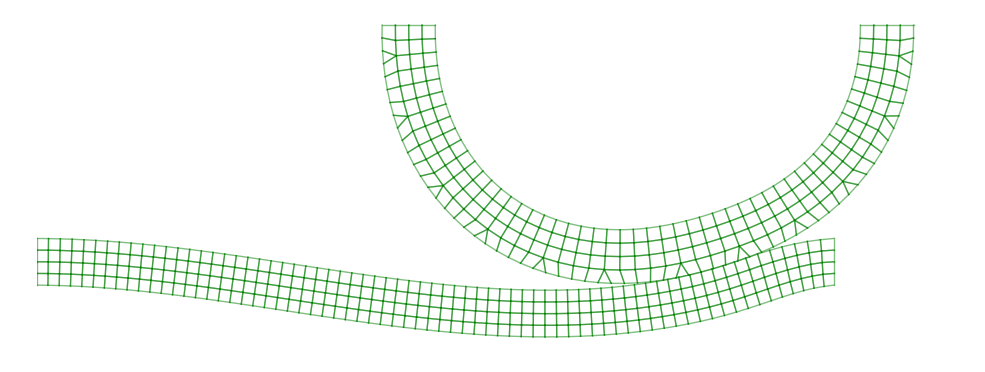

(0.0,35.0,-2.0,10.0)

INFO: PDASS: contact nodes: [5,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146]
INFO: PDASS: active nodes: [134,135,136,137,138,139,140]
INFO: PDASS: inactive nodes: [5,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,141,142,143,144,145,146]
INFO: UMFPACK: solved in 0.013537883758544922 seconds. norm = 39.0805994302936
INFO: Converged in 19 iterations.


In [4]:
function plot_it(field_problem, scaling_factor=1, time=0.0; show_undeformed=true,
    show_deformed=true, show_node_ids=true, equal_axis=true, xmin=-1000, ymin=-1000, xmax=1000, ymax=1000)

    function in_window(X)
        xmin < X[1] < xmax || return false
        ymin < X[2] < ymax || return false
        return true
    end

    for element in field_problem.elements
        conn = get_connectivity(element)
        X = element("geometry", time)
        
        u = element("displacement", time)
        x = X + scaling_factor*u

        if show_undeformed
            # undeformed
            for i=1:length(X)
                in_window(X[i]) || continue
                px1 = X[i][1]
                py1 = X[i][2]
                px2 = X[mod(i,length(X))+1][1]
                py2 = X[mod(i,length(X))+1][2]
                PyPlot.plot([px1, px2], [py1, py2], "k-", alpha=0.5, label="undeformed")
            end
        end

        if show_deformed
            # deformed
            for i=1:length(x)
                in_window(x[i]) || continue
                px1 = x[i][1]
                py1 = x[i][2]
                px2 = x[mod(i,length(x))+1][1]
                py2 = x[mod(i,length(x))+1][2]
                PyPlot.plot([px1, px2], [py1, py2], "g-", alpha=0.5, label="deformed")
            end
        end

        if show_node_ids
            for (i, c) in enumerate(conn)
                in_window(x[i]) || continue
                PyPlot.text(x[i][1], x[i][2], "$c")
            end
        end
        
    end

    if equal_axis
        PyPlot.axis("equal")
    end
    #PyPlot.grid()

end

using JuliaFEM.Core: project_from_master_to_slave, project_from_slave_to_master

function plot_normals(contact_problem, time, scale=3)
    for element in get_elements(contact_problem)
        X1 = element("geometry", [-1.0], time)
        X2 = element("geometry", [ 1.0], time)
        n1 = element("normal-tangential coordinates", [-1.0], time)
        n2 = element("normal-tangential coordinates", [ 1.0], time)
        plot([X1[1], X1[1]+scale*n1[1]], [X1[2], X1[2]+scale*n1[2]], "-b")
        plot([X2[1], X2[1]+scale*n2[1]], [X2[2], X2[2]+scale*n2[2]], "-b")
    end
end

function plot_contact_segmentation(slave_element, time)
    for master_element in slave_element["master elements"]
        xi1a = 0
        xi1b = 0
        try
            xi1a = project_from_master_to_slave(slave_element, master_element, [-1.0])
            xi1b = project_from_master_to_slave(slave_element, master_element, [ 1.0])
        catch
            info("failed get construct segmentation")
        end
        xi1 = clamp([xi1a xi1b], -1.0, 1.0)
        l = 1/2*(xi1[2]-xi1[1])
        if abs(l) < 1.0e-9
            continue
        end
        Xs1 = slave_element("geometry", [xi1[1]], time)
        Xs2 = slave_element("geometry", [xi1[2]], time)
        xi2a = project_from_slave_to_master(slave_element, master_element, [xi1[1]])
        xi2b = project_from_slave_to_master(slave_element, master_element, [xi1[2]])
        Xm1 = master_element("geometry", xi2a, time)
        Xm2 = master_element("geometry", xi2b, time)
        plot([Xs1[1], Xm1[1]], [Xs1[2], Xm1[2]], "-r", alpha=0.3)
        plot([Xs2[1], Xm2[1]], [Xs2[2], Xm2[2]], "-r", alpha=0.3)
    end
end

function plot_segmentation(contact_problem, time=0.0)
    info("plot segmentation")
    for (i, element) in enumerate(get_elements(contact_problem))
        haskey(element, "master elements") || continue
        plot_contact_segmentation(element, time)
    end
end


figure(figsize=(12, 4))
plot_it(body1; show_undeformed=false, equal_axis=false, show_node_ids=false)
plot_it(body2; show_undeformed=false, equal_axis=false, show_node_ids=false)
#plot_segmentation(bc3)
#xlim(-0.1, 1.1)
#ylim(0.30, 0.52)
#axis("off")

element = nothing
for element in get_elements(bc3)
    continue
    haskey(element, "master elements") || continue
    haskey(element, "active nodes") || continue
    A = element["active nodes"]
    X = element("geometry", [0.0], 0.0)
    u = element("displacement", [0.0], 0.0)

    G = element["G"].data
    isapprox(G, [0.0, 0.0, 0.0, 0.0]) && continue
    println(A.data)
    println(element["c"].data[1:2:end])
    x = X + u
    plot(x[1], x[2], "ro")
end
axis("off")